In [24]:
#setup
data_dir='../../Data/Weather'
file_index='SSSBSSBB'
meas='PRCP'

# Reconstruction using top eigen-vectors
For measurement = {{meas}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==meas)
df.show(5)

+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|            coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|-400.25580116183414|-232.79174671469505| 341.86307158597043|    806.2|SSSBSSBB| 37.2328|-119.5097|       PRCP|0.9265298783406835|0.9116226336125848|0.8537499263315288|0.8796015508153012|USC00046252|3000042.0|    31|[58 60 00 4D 20 5...|2005.0|
| 149.21559745866517

### Plot Mean and Eigenvecs

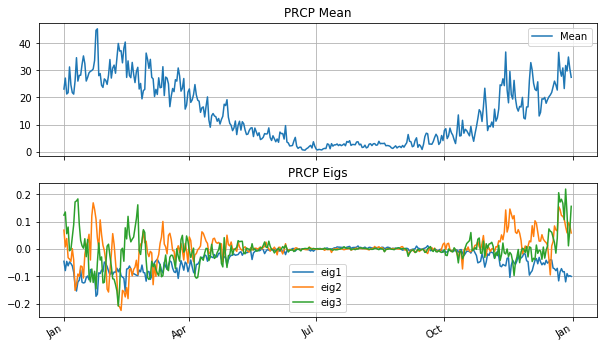

In [7]:
m=meas
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

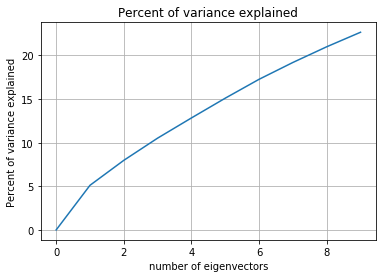

In [9]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [10]:
# A function for plotting the CDF of a given feature
def plot_CDF(df,feat):
    rows=df.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    while len(vals)< len(P):
        vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('fraction of instances')
    xlabel(feat)
    grid()
    

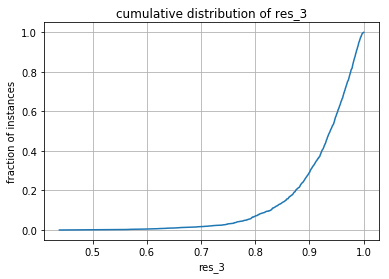

In [11]:
plot_CDF(df,'res_3')

In [12]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
rows[0][:2]

(u'USC00046252', 2005.0)

In [26]:
rows[:5]

[(u'USC00046252',
  2005.0,
  array([ 556.,   20.,   33.,  224.,   79.,    0.,    0.,   nan,  419.,
          406.,  224.,  282.,  193.,   25.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    5.,   36.,
          371.,   69.,  198.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,   89.,   51.,    0.,    0.,    5.,  147.,    8.,    0.,
           38.,  292.,   33.,   86.,   91.,  371.,  155.,  112.,    0.,
           71.,   20.,    0.,    0.,  282.,    0.,   28.,    0.,   25.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,  142.,  358.,  104.,
          396.,  582.,   64.,   38.,    0.,    0.,  157.,   13.,   30.,
            0.,   nan,   nan,   nan,    3.,    0.,    0.,   51.,   nan,
           nan,   nan,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,   nan,   nan,   nan,    0.,    0.,
           25.,   89.,    0.,   nan,

In [27]:
days=set([r[1] for r in rows])
miny=min(days)
maxy=max(days)
record_len=int((maxy-miny+1)*365)
record_len

43800

In [28]:
## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector

In [29]:
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]

In [30]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

USC00043939 32422
USC00043369 20728
USC00049633 5791
USC00263285 702
USC00047817 364
USC00049855 28764
USC00043261 20617
USC00040755 17273
USC00045541 5771
USW00053150 1810
USC00040819 6732
USC00045400 18505
USW00023203 5075
USC00044679 13917
USC00045779 9402
USC00041630 5489
USC00048406 16572
USC00045496 9100
USC00045535 355
US1CAMP0004 730
USC00049632 2887
USC00043669 5004
USC00049065 3944
US1CAMP0003 327
US1CAMP0002 716
USC00044884 16119
USS0019L13S 6121
USC00045078 712
USC00264560 364
USC00044881 6328
USC00049481 1781
USC00048353 29328
USC00042756 23817
US1CAMN0001 656
USC00265931 3132
USC00040379 29571
USC00043093 720
USC00044176 26985
USC00049482 353
USC00044170 5454
USC00041697 19256
USC00048499 6158
USC00041590 698
US1CACV0004 358
USC00041280 2852
USC00040820 969
USC00043666 3954
US1CASS0001 1367
USC00045346 23741
US1CAMA0001 708
USC00042173 1445
USC00042389 15530
USC00045352 6657
US1CAMA0002 350
USC00041878 8663
USC00045532 23019
US1CAMA0003 339
USC00260046 6522
USC00044705 15

In [62]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

(78, 43800)


In [68]:
Stations

[u'US1CACV0004',
 u'US1CAIN0002',
 u'US1CAMA0001',
 u'US1CAMA0002',
 u'US1CAMA0003',
 u'US1CAMN0001',
 u'US1CAMP0001',
 u'US1CAMP0002',
 u'US1CAMP0003',
 u'US1CAMP0004',
 u'US1CASS0001',
 u'USC00040379',
 u'USC00040684',
 u'USC00040755',
 u'USC00040819',
 u'USC00040820',
 u'USC00041280',
 u'USC00041588',
 u'USC00041590',
 u'USC00041611',
 u'USC00041630',
 u'USC00041697',
 u'USC00041878',
 u'USC00042173',
 u'USC00042389',
 u'USC00042539',
 u'USC00042756',
 u'USC00042920',
 u'USC00043093',
 u'USC00043261',
 u'USC00043369',
 u'USC00043666',
 u'USC00043669',
 u'USC00043672',
 u'USC00043939',
 u'USC00044170',
 u'USC00044176',
 u'USC00044590',
 u'USC00044679',
 u'USC00044705',
 u'USC00044881',
 u'USC00044884',
 u'USC00045078',
 u'USC00045280',
 u'USC00045346',
 u'USC00045352',
 u'USC00045400',
 u'USC00045496',
 u'USC00045532',
 u'USC00045535',
 u'USC00045541',
 u'USC00045779',
 u'USC00046172',
 u'USC00046174',
 u'USC00046252',
 u'USC00047272',
 u'USC00047702',
 u'USC00047817',
 u'USC00048353

In [32]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_day=np.nanmean(day_station_table,axis=0)
mean_by_station=np.nanmean(day_station_table,axis=1)
tbl_minus_day = day_station_table-mean_by_day
tbl_minus_station = (day_station_table.transpose()-mean_by_station).transpose()

print 'total RMS                   = ',RMS(day_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-day   = ',RMS(tbl_minus_day)

total RMS                   =  68.4516140492
RMS removing mean-by-station=  65.8425511828
RMS removing mean-by-day   =  41.0464333579


In [33]:
RT=day_station_table
F=RT.flatten()
NN=F[~np.isnan(F)]

NN.sort()
P=np.arange(0.,1.,1./len(NN))
plot(NN,P)
grid()
title('CDF of daily rainfall')
xlabel('daily rainfall')
ylabel('cumulative probability')

### Conclusions
It is likely to be hard to find correlations between the **amount** of rain on the same day in different stations. Because amounts of rain vary a lot between even close locations. It is more reasonable to try to compare whether or not it rained on the same day in different stations. As we see from the graph above, in our region it rains in about one third of the days.

### measuring statistical significance
We want to find a statistical test for rejecting the null hypothesis that says that the rainfall in the two locations is independent.

Using the inner product is too noisy, because you multiply the rainfall on the same day in two locations and that product can be very large - leading to a large variance and poor ability to discriminate.

An alternative is to ignore the amount of rain, and just ask whether it rained in both locations. We can then compute the probability associated with the number of overlaps under the null hypothesis.

Fix two stations. We restrict our attention to the days for which we have measurements for both stations, and define the following notation:
* $m$ : the total number of days (for which we have measurements for both stations).
* $n_1$ : the number of days that it rained on station 1
* $n_2$ : the number of days that it rained on station 2
* $l$ : the number of days that it rained on both stations.

We want to calculate the probability that the number of overlap days is $l$ given $m,n_1,n_2$.

The answer is:
$$
P = {m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} /{m \choose n_1}{m \choose n_2}
$$

Where
$$
{m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} = \frac{m!}{l! (n_1-l)! (n_2-l)! (m-n_1-n_2+l)!}
$$

We use the fact that $\Gamma(n+1) = n!$ and denote $G(n) \doteq \log \Gamma(n+1)$
$$
\log P = \left[G(m) - G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) \right] - 
\left[G(m)-G(n_1)-G(m-n_1)\right] - \left[G(m)-G(n_2)-G(m-n_2)\right]
$$
Which slightly simplifies to 
$$
\log P = -G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) - G(m)+G(n_1)+G(m-n_1) +G(n_2)+G(m-n_2)
$$

The log probability scales with $m$ the length of the overlap. So to get a per-day significance we consider $
\frac{1}{m} \log P $

In [34]:
from scipy.special import gammaln,factorial
#for i in range(10):
#    print exp(gammaln(i+1))-factorial(i)
def G(n):
    return gammaln(n+1)
def LogProb(m,l,n1,n2):
    logP=-G(l)-G(n1-l)-G(n2-l)-G(m-n1-n2+l)-G(m)+G(n1)+G(m-n1)+G(n2)+G(m-n2)
    return logP/m
exp(LogProb(1000,0,500,500))

0.501843349103545

In [35]:
#USC00193270 21482
#USC00193702 28237

#USC00049073 21282
#USC00042539 21592
X=copy(All['USC00049073'])
Y=copy(All['USC00042539'])
print sum(~np.isnan(X))
print sum(~np.isnan(Y))
X[np.isnan(Y)]=np.nan
Y[np.isnan(X)]=np.nan
print sum(~np.isnan(X))
print sum(~np.isnan(Y))


21282
21592
10359
10359


In [36]:
def computeLogProb(X,Y):
    X[np.isnan(Y)]=np.nan
    Y[np.isnan(X)]=np.nan
    G=~isnan(X)
    m=sum(G)
    XG=X[G]>0
    YG=Y[G]>0
    n1=sum(XG)
    n2=sum(YG)
    l=sum(XG*YG)
    logprob=LogProb(m,l,n1,n2)
    # print 'm=%d,l=%d,n1=%d,n2=%d,LogPval=%f'%(m,l,n1,n2,logprob)
    return logprob,m
print computeLogProb(X,Y)

(-0.15367904500989227, 10359)


### calculate the normalized log probability for each pair of stations.

In [37]:
L=len(Stations)
Pvals=np.zeros([L,L])
Length=np.zeros([L,L])
P_norm=np.zeros([L,L])
for i in range(L):
    print i,
    for j in range(L):
        if i==j: 
            P_norm[i,j]=-0.4
            continue
        X=copy(All[Stations[i]])
        Y=copy(All[Stations[j]])
        P_norm[i,j],Length[i,j]=computeLogProb(X,Y)
        if Length[i,j]<200:
            P_norm[i,j]=np.nan

            

0 1 2 3 4 5 6 7 8

/Users/andy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77


In [38]:
P_norm

array([[-0.4       ,         nan,         nan, ...,         nan,
        -0.06725445, -0.1070319 ],
       [        nan, -0.4       ,         nan, ...,         nan,
        -0.05252564, -0.06278422],
       [        nan,         nan, -0.4       , ...,         nan,
        -0.07638292, -0.11337881],
       ..., 
       [        nan,         nan,         nan, ..., -0.4       ,
                nan,         nan],
       [-0.06725445, -0.05252564, -0.07638292, ...,         nan,
        -0.4       , -0.19530344],
       [-0.1070319 , -0.06278422, -0.11337881, ...,         nan,
        -0.19530344, -0.4       ]])

In [39]:
print Pvals[:2,:2]
print Length[:2,:2]
print P_norm[:2,:2]

[[ 0.  0.]
 [ 0.  0.]]
[[ 0.  0.]
 [ 0.  0.]]
[[-0.4  nan]
 [ nan -0.4]]


(6084,) (3376,)


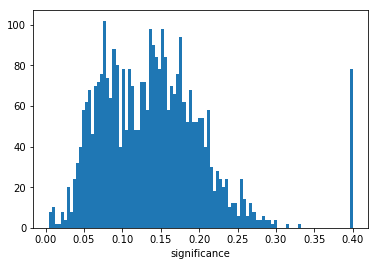

In [40]:
A=P_norm.flatten();
B=A[~isnan(A)]
print A.shape,B.shape
hist(-B,bins=100);
xlabel('significance')

In [41]:
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.imshow(mat, cmap=plt.cm.gray)

In [42]:
showmat(P_norm)

### Finding structure in the rependency matrix.
The matrix above shows, for each pair of stations, the normalized log probability that the overlap in rain days is random.

We see immediately the first 8 stations are highly correlatedwith each other. 

To find more correlations we use SVD (the term PCA is reserved for decomposition of the covariance matrix). As we shall see that the top 10 eigenvectors explain about 80% of the square magnitude of the matrix.

In [43]:
print 'A group of very correlated stations is:',All.keys()[:8]

A group of very correlated stations is: [u'USC00043939', u'USC00043369', u'USC00049633', u'USC00263285', u'USC00047817', u'USC00049855', u'USC00043261', u'USC00040755']


In [44]:
from sklearn.decomposition import PCA
P_norm0 = np.nan_to_num(P_norm)
n_comp=10
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     
#print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(insert(cumsum(Var_explained),0,0))
grid()

In [50]:
P_norm0

array([[-0.4       ,  0.        ,  0.        , ...,  0.        ,
        -0.06725445, -0.1070319 ],
       [ 0.        , -0.4       ,  0.        , ...,  0.        ,
        -0.05252564, -0.06278422],
       [ 0.        ,  0.        , -0.4       , ...,  0.        ,
        -0.07638292, -0.11337881],
       ..., 
       [ 0.        ,  0.        ,  0.        , ..., -0.4       ,
         0.        ,  0.        ],
       [-0.06725445, -0.05252564, -0.07638292, ...,  0.        ,
        -0.4       , -0.19530344],
       [-0.1070319 , -0.06278422, -0.11337881, ...,  0.        ,
        -0.19530344, -0.4       ]])

In [45]:
# we will look only at the top 4 eigenvectors.
n_comp=4
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [46]:
fig,axes=plt.subplots(1,4,figsize=(20,5),sharey='row');
L=list(pca.components_.transpose())
for i in range(4):
    X=sorted(L,key=lambda x:x[i]) 
    axes[i].plot(X);

In [51]:
L

[array([-0.04052962, -0.15283723,  0.03605537, -0.00538629]),
 array([-0.03303749, -0.09672328,  0.03249834, -0.01388012]),
 array([-0.13082479, -0.24324595, -0.02984799, -0.00884228]),
 array([-0.14854793, -0.20966315, -0.07121254, -0.01942652]),
 array([-0.13453851, -0.18377243, -0.06298335, -0.02089446]),
 array([-0.10356884, -0.16358948, -0.01865497, -0.01405243]),
 array([-0.13892631, -0.28986298, -0.00219306, -0.00983509]),
 array([-0.13251339, -0.23662437, -0.03151754, -0.00690031]),
 array([-0.14753069, -0.21514545, -0.07070217, -0.01868062]),
 array([-0.12937604, -0.2266196 , -0.03151065, -0.00887273]),
 array([-0.12634636, -0.23940406, -0.00294526, -0.00291538]),
 array([  3.52352906e-02,  -8.49525161e-02,   5.72226148e-05,
          8.02762449e-03]),
 array([ 0.01465041,  0.02481944,  0.09196478, -0.04709302]),
 array([ 0.16045307, -0.04774123, -0.02364473, -0.08794522]),
 array([ 0.03660527,  0.01415566,  0.14565972, -0.09211308]),
 array([-0.00953385, -0.02966835,  0.03470

In [47]:
def re_order_matrix(M,order):
    M_reord=M[order,:]
    M_reord=M_reord[:,order]
    return M_reord

In [48]:
fig,axes=plt.subplots(2,2,figsize=(15,15),sharex='col',sharey='row');
i=0
for r in range(2):
    for c in range(2):
        order=np.argsort(pca.components_[i,:])
        P_norm_reord=re_order_matrix(P_norm0,order)
        axes[r,c].matshow(P_norm_reord)
        i+=1


### Explanation and possibe extensions
When we reorder the rows and columns of the matrix using one of the eigenvectors, the grouping of the 
stations becomes more evident. For example, consider the upper left corner of the scond matrix (The upper left one). The stations at positions 0-22 are clearly strongly correlated with each other. Even though there are some stations, in positions 15-18 or so, which are more related to each other than to the rest of this block.

This type of organization is called **Block Diagonal** and it typically reveals important structure such as grouping or clustering.

You might want to extract the sets of stations that form blocks for your region, and then plot them on the map to see their spatial relationship.

In [49]:
from pickle import dump
with open(data_dir+'/PRCP_residuals_PCA.pickle','wb') as file:
    dump({'stations':All.keys(),
          'eigen-vecs':pca.components_},
        file)
    